<a href="https://colab.research.google.com/github/ArTeDS/Sentiment-Analysis-on-Streaming-Covid_19-Tweets/blob/main/covid_tweets_real_fake_detection_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold, LeaveOneOut, KFold, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer, plot_confusion_matrix, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

df = pd.read_csv('Constraint_English_Train.csv')

df.label.value_counts()
df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [ ]:
# create column with labels as boolean
label_bool = {'fake': 0,
            'real': 1}

df['label_bool'] = df['label'].map(label_bool)
df

,id,tweet,label,label_bool
0,1,The CDC currently reports 99031 deaths. In gen...,real,1
1,2,States reported 1121 deaths a small rise from ...,real,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,1
4,5,Populous states can generate large case counts...,real,1
...,...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake,0


In [ ]:
# Function for text preprocessing

#! pip install beautifulsoup4
# !pip install spacy
# !python -m spacy download en_core_web_sm
# nltk.download('words')
# nltk.download('stopwords')

# Function for text preprocessing
import string
import re
import nltk
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#from bs4 import BeautifulSoup
import spacy

# set puncuation and stopwords into one list
punctuation = list(string.punctuation)
# punctuation.remove('-')

# english stopwords
stopwords = nltk.corpus.stopwords.words('english')

# load spaCY english language
nlp = spacy.load('en_core_web_sm')

# Snowball Stemmer
stemmer = SnowballStemmer('english')


def preprocess(df, s_column, t_column, lemmatize=False, stem=False):
    
    # df: DataFrame
    # s_column: source column. The one that is to be processed
    # t_column: target column. The one created with the preprocessed text
    
    # lowercase
    
    df[t_column] = df[s_column].str.lower()
    
    # removes specials characters and leaves only words
    #df[t_column] = df[t_column].apply(lambda x : (re.sub('\W_',' ', x)))
    
     # remove whitespaces
    df[t_column] = df[t_column].apply(lambda x : ( re.sub(' +', ' ', x)))
    
#     # remove - 
#     df[t_column] = df[t_column].apply(lambda x : ( re.sub('-', ' ', x)))
    
    # remove HTML Tags
    #df[t_column] = df[t_column].apply(lambda x : BeautifulSoup(x,'html.parser').get_text())
    
    # remove numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    df[t_column] = df[t_column].apply(lambda x : (re.sub("\S*\d\S*"," ", x)))
    
    # removes emails and mentions (words with @)
    df[t_column] = df[t_column].apply(lambda x : (re.sub("\S*@\S*\s?"," ", x)))
    
    # remove url 
    df[t_column] = df[t_column].apply(lambda x : ( re.sub(r'http\S+|www.\S+', r'', x)))
    
    if lemmatize == True:
        df[t_column] = df[t_column].apply(lambda x: ' '.join([w.lemma_ for w in nlp(x)]))
    
    # remove words with less than 3 letters 
    df[t_column] = df[t_column].apply(lambda x : (re.sub(r'\b\w{1,2}\b', '', x)))
    
    # remove noise (e.g. numbers, symbols)
    #df[t_column] = df[t_column].apply(lambda x : (re.sub('[^a-z\s]', ' ',x)))
    
    # remove punctuation
    df[t_column] = df[t_column].apply(lambda x: ''.join([word for word in x if word not in (punctuation)]))
    
    # remove words with 14 or more letters
    df[t_column] = df[t_column].apply(lambda x : (re.sub(r'\b\w{14,1000}\b', '', x)))
    
    # remove non-english words
    #df[t_column] = df[t_column].apply(lambda x: ' '.join([word for word in nltk.wordpunct_tokenize(x) if word in eng_words_full or not word.isalpha()]))
    
        
    # stem every word
    if stem == True:
        # remove stopwords
        df[t_column] = df[t_column].apply(lambda x: ([word for word in x.split() if word not in (stopwords)]))
        
        # stemmer
        df[t_column] = df[t_column].apply(lambda x: ', '.join([stemmer.stem(y) for y in x])) 
    
    else:
        # remove stopwords
        df[t_column] = df[t_column].apply(lambda x: ', '.join([word for word in x.split() if word not in (stopwords)]))
        
    return df
    

In [ ]:
preprocess(df, 'tweet', 'tokens', lemmatize=True)

,id,tweet,label,label_bool,tokens
0,1,The CDC currently reports 99031 deaths. In gen...,real,1,"cdc, currently, report, death, general, discre..."
1,2,States reported 1121 deaths a small rise from ...,real,1,"state, report, death, small, rise, last, tuesd..."
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,0,"politically, correct, woman, almost, use, pand..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,1,"covid, testing, laboratory, india, august, tes..."
4,5,Populous states can generate large case counts...,real,1,"populous, state, generate, large, case, count,..."
...,...,...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake,0,"tiger, test, positive, please, stay, away, pet..."
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake,0,"autopsy, prove, �, blood, clot, pneumonia, oug..."
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake,0,"post, claim, vaccine, already, develop, cause,..."
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake,0,"aamir, khan, donate, relief, care, fund"


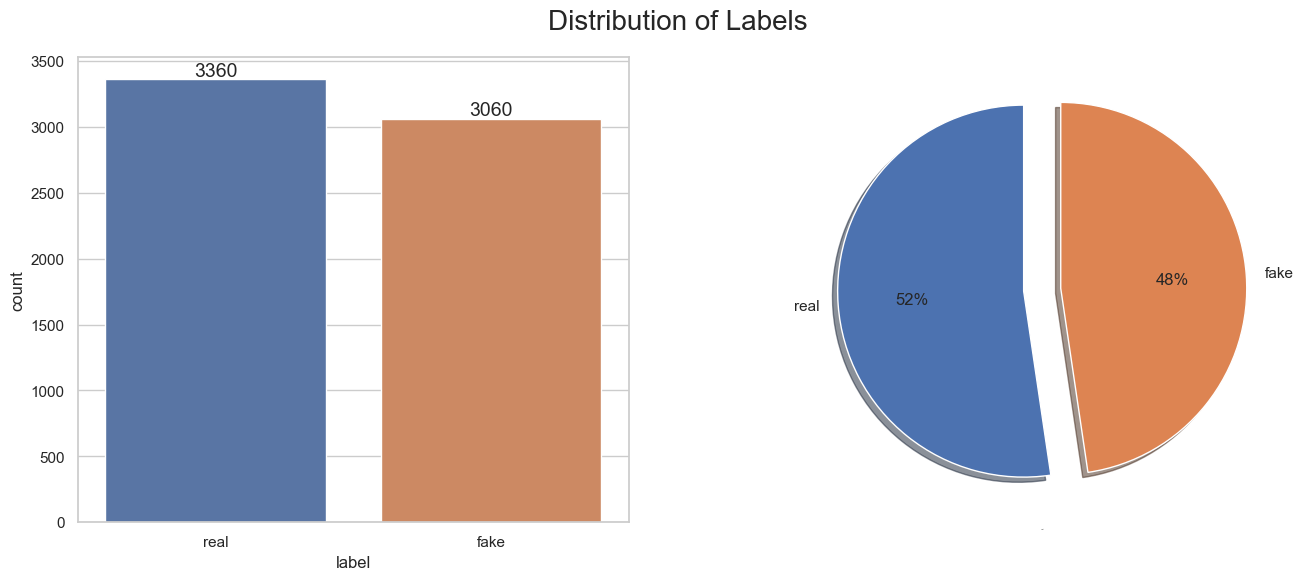

In [ ]:
# plot labels count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(16, 6), 
                         dpi=100)
fig.subplots_adjust(top=0.9, wspace=0.25)

g = sns.countplot(x=df['label'], ax=axes[0],  
              order=['real', 'fake'])

labels=['real', 'fake']

# add annotations to bar chart
for bar in g.patches:
    g.annotate(format(bar.get_height(), '.0f'),  # the number before f represents the decimals 
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=14, xytext=(0, 6), 
                   textcoords='offset points')

axes[1].pie(df['label'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.1, 0.1))

plt.tick_params(direction='out', axis='x', labelsize=20, length=6, width=2, grid_alpha=0.5)
plt.xlabel('count',size=0) 
plt.ylabel('', size=0) 

sns.color_palette("pastel")
 
fig.suptitle('Distribution of Labels', fontsize=20)
plt.show()

### Feature Extraction

In [ ]:
# Vectorizers (Count and TF-IDF)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# instantiate the vectorizer objects
countvectorizer = CountVectorizer() 
countvectorizer_ngrams = CountVectorizer(ngram_range=(1, 2)) # with n-grams

tfidfvectorizer = TfidfVectorizer(sublinear_tf=True)
tfidfvectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True) # with n-grams


# convert the documents into a matrix
count = countvectorizer.fit_transform(df.tokens)
count_ngrams = countvectorizer_ngrams.fit_transform(df.tokens) # with n-grams

tfidf = tfidfvectorizer.fit_transform(df.tokens)
tfidf_ngrams = tfidfvectorizer_ngrams.fit_transform(df.tokens) # with n-grams

# getting the vocabulary of tokens
count_tokens = countvectorizer.get_feature_names()
count_ngrams_tokens = countvectorizer_ngrams.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()
tfidf_ngrams_tokens = tfidfvectorizer_ngrams.get_feature_names()

# vector representation
df_countvect = pd.DataFrame(data = count.toarray(),columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf.toarray(),columns = tfidf_tokens) # tf-idf

# print("\nTD-IDF Vectorizer\n")
# print(tfidf)
# print(tfidf_tokens)
# df_tfidfvect
#print(df_tfidfvect.shape)
print('Number of unigrams:', len(count_tokens))
print('Number of unigrams and bigrams:', len(tfidf_ngrams_tokens))

Number of unigrams: 8669
Number of unigrams and bigrams: 60722


### Feature Selection with Chi-Square

In [ ]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y = df['label_bool']

#feature selection with Chi Square
chi2_features = SelectKBest(chi2, k=3000)
chi2_features_ngrams = SelectKBest(chi2, k=6500)


X_count = chi2_features.fit_transform(count, y)
X_count_ngrams = chi2_features_ngrams.fit_transform(count_ngrams, y)
X_tfidf = chi2_features.fit_transform(tfidf, y)
X_tfidf_ngrams = chi2_features_ngrams.fit_transform(tfidf_ngrams, y)


# passing the different Xs into a dictionary as to be used later in fitting and scoring
X_dict = {'X_count':X_count, 'X_count_ngrams':X_count_ngrams, 
        'X_tfidf':X_tfidf, 'X_tfidf_ngrams':X_tfidf_ngrams}

X_count.shape[1]

3000

### Functions for cross-validation and GridSearch

In [ ]:
'''
Custom function for classification scoring with Stratified K-fold validation.
'''

# Define the scoring metrics and the average methods
scorer = {'accuracy': 'accuracy',
          'roc_auc': make_scorer(roc_auc_score),
           'precision': make_scorer(precision_score, zero_division=1),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

# Stratified Repeated cross validation
#cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=25, random_state=42)
#cv = LeaveOneOut()
def cross_validation_scores(clf, X, y, scoring=scorer):
    
    '''
    Defining a function for the cross-validation which returns the mean scores of each metric

    clf: scikit-learn classification model
    X: features (no labels)
    y: labels
    scoring: a dictionary of scoring metrics
    '''
    # Cross Validation with the stratified repeated cross validator
    scores = cross_validate(clf, X, y, scoring=scorer, cv=cv, n_jobs=-1)

    # Getting the mean score of each metric
    # print('>%s %.3f (%.3f) \n' % (name, np.mean(scores), np.std(scores)))
    return {metric: (round(np.mean(scores), 3)
                     , [round(np.std(scores), 3)]) for metric, scores in scores.items()}

In [ ]:
'''
Function for scoring the classifiers with the previously defined cross validation scoring function, and
for storing the scores into a Pandas Dataframa
'''
def report(clf, X, y, name='classifier'):

    scores = cross_validation_scores(clf, X, y)

    df = pd.DataFrame()
    df = pd.DataFrame.from_dict([scores])
    df['Classifier'] = name
    df = df.set_index('Classifier')
   # df = df.reset_index()
    
    return df

In [ ]:
''''
Function for finding the optimal parameters of the classifier using GrindSearchCV. 
In the scoring parameter I pass the scorer dict that I created for multiscoring. 
For the refit parameter, any score metric of the dict (i.e. accuracy, precision, recall, roc_auc) can be given.
setting the previously defined stratified repeated cross validation as cv
'''
def optimal_params(clf, parameters, search_all=True, **kwargs):
    gsc = GridSearchCV(clf, parameters, cv=cv, scoring=scorer, refit='accuracy', n_jobs=-1)
    
    '''
    search_all: If True (default), the Grindsearch will search the parameters for every X. 
    If False, the user defines which X will be searched by Grindsearch. Use X=[]
    '''
    
    # Fit as to get the results of the GridSearch
    if search_all==True:
        for key, X in X_dict.items(): 
            grid_result = gsc.fit(X, y)
            
            print("For {}: " .format (key), grid_result.best_params_)
    else:
        X = kwargs.get('X')
        for x in X:
            grid_result = gsc.fit(x, y)
        
            print(grid_result.best_params_)

## __Classifiers__

### Naive Bayes (Multinomial)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create a Naive Bayes Classifier as to use it with GrindSearchCV
MNB = MultinomialNB()


# Getting the parameters of the classifier
#MNB.get_params()

In [ ]:
MNB_params_2 = {'alpha':(0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5),
                 'fit_prior': (True, False)}

In [ ]:
optimal_params(MNB, MNB_params_2, search_all=False, X=[X_tfidf, X_tfidf_ngrams])

{'alpha': 0.01, 'fit_prior': False}
{'alpha': 0.01, 'fit_prior': False}


In [ ]:
# Creating the Naive Bayes Classifier with the optimal parameters
# MNB_count = MultinomialNB(alpha=0.1, fit_prior=True)
# MNB_count_ngrams = MultinomialNB(alpha=0.01, fit_prior=False)
MNB_tfidf = MultinomialNB(alpha=0.01, fit_prior=False)
MNB_tfidf_ngrams = MultinomialNB(alpha=0.01, fit_prior=False)

In [ ]:
# create a test dataframe in which all the scores will be stored
df_results = pd.DataFrame()

# scoring each version of the classifier
# df_results = df_results.append(report(MNB_count, X_count, y, name='MNB_count'))
# df_results = df_results.append(report(MNB_count_ngrams, X_count_ngrams, y, name='MNB_count_ngrams'))
df_results = df_results.append(report(MNB_tfidf, X_tfidf, y, name='MNB_tfidf'))
df_results = df_results.append(report(MNB_tfidf_ngrams, X_tfidf_ngrams, y, name='MNB_tfidf_ngrams'))

df_results.sort_values(by=['test_accuracy'], ascending=False)

,fit_time,score_time,test_accuracy,test_roc_auc,test_precision,test_recall,test_f1
Classifier,,,,,,,
MNB_tfidf_ngrams,"(0.005, [0.007])","(0.008, [0.008])","(0.949, [0.005])","(0.949, [0.005])","(0.96, [0.007])","(0.942, [0.008])","(0.951, [0.005])"
MNB_tfidf,"(0.009, [0.008])","(0.011, [0.007])","(0.935, [0.005])","(0.934, [0.005])","(0.936, [0.007])","(0.94, [0.008])","(0.938, [0.005])"


In [ ]:
from sklearn.pipeline import Pipeline
def fit(words, y):
    pipe = Pipeline([

        #('preprocess', preprocess(df, 'tweet', 'tokens', lemmatize=True)),  
        #('col_selector', ColumnSelector(cols=('tweet'),drop_axis=True)),
        ('tfidf_ngrams', tfidfvectorizer_ngrams),
        #('chi2_features_ngrams', chi2_features_ngrams),
        ('MNB_tfidf_ngrams', MNB_tfidf_ngrams)
    ])


    return pipe.fit(words, y)


In [ ]:
model = fit(df.tokens, y)

In [ ]:
MNB_tfidf_ngrams.fit(X_tfidf_ngrams, y)

MultinomialNB(alpha=0.01, fit_prior=False)

In [ ]:
# save model
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'MNB_Covid_Tweets_Real_Fake.pkl')
 
# # Load the model from the file
# knn_from_joblib = joblib.load('filename.pkl')
 
# # Use the loaded model to make predictions
# knn_from_joblib.predict(X_test)

['MNB_Covid_Tweets_Real_Fake.pkl']

In [ ]:
df_val = pd.read_csv('Constraint_English_Val.csv')

In [ ]:
preprocess(df_val, 'tweet', 'tokens', lemmatize=True)

,id,tweet,label,tokens
0,1,Chinese converting to Islam after realising th...,fake,"chinese, convert, islam, realise, muslim, affe..."
1,2,11 out of 13 people (from the Diamond Princess...,fake,"people, diamond, princess, cruise, ship, intia..."
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,"cause, bacterium, virus, treat, aspirin"
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,"mike, pence, rnc, speech, praise, donald, trum..."
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,"sky, explain, late, datum, government, announc..."
...,...,...,...,...
2135,2136,Donald Trump wrongly claimed that New Zealand ...,fake,"donald, trump, wrongly, claim, new, zealand, b..."
2136,2137,Current understanding is #COVID19 spreads most...,real,"current, understanding, spread, mostly, person..."
2137,2138,Nothing screams “I am sat around doing fuck al...,fake,"nothing, scream, sit, around, fuck, lockdown, ..."
2138,2139,Birx says COVID-19 outbreak not under control ...,fake,"birx, say, outbreak, control, people, move"


In [ ]:
# create column with labels as boolean
label_bool = {'fake': 0,
            'real': 1}

df_val['label_bool'] = df_val['label'].map(label_bool)
df_val

,id,tweet,label,tokens,label_bool
0,1,Chinese converting to Islam after realising th...,fake,"chinese, convert, islam, realise, muslim, affe...",0
1,2,11 out of 13 people (from the Diamond Princess...,fake,"people, diamond, princess, cruise, ship, intia...",0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,"cause, bacterium, virus, treat, aspirin",0
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,"mike, pence, rnc, speech, praise, donald, trum...",0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,"sky, explain, late, datum, government, announc...",1
...,...,...,...,...,...
2135,2136,Donald Trump wrongly claimed that New Zealand ...,fake,"donald, trump, wrongly, claim, new, zealand, b...",0
2136,2137,Current understanding is #COVID19 spreads most...,real,"current, understanding, spread, mostly, person...",1
2137,2138,Nothing screams “I am sat around doing fuck al...,fake,"nothing, scream, sit, around, fuck, lockdown, ...",0
2138,2139,Birx says COVID-19 outbreak not under control ...,fake,"birx, say, outbreak, control, people, move",0


In [ ]:
y_val = df_val['label_bool']

In [ ]:
# # Load the model from the file
MNB_Covid_Tweets_Real_Fake = joblib.load('MNB_Covid_Tweets_Real_Fake.pkl')
 
y_pred = MNB_Covid_Tweets_Real_Fake.predict(df_val.tokens)

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
print(confusion_matrix(y_val, y_pred))

[[ 934   86]
 [  84 1036]]


In [ ]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1020
           1       0.92      0.93      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



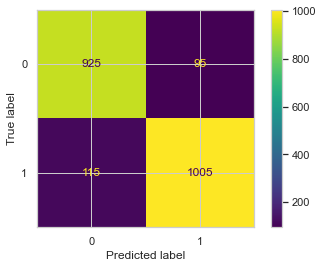

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-deep")
plot_confusion_matrix(MNB_Covid_Tweets_Real_Fake, df_val.tokens, y_val)
plt.show()